<a href="https://colab.research.google.com/github/bchenley/TorchTimeSeries/blob/main/notebooks/TorchTimeSeries_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to walk through how to use TorchTimeSeries for time series modeling.

**Step 1: Clone the TorchTimeSeries Repository**

The first step is to clone the TorchTimeSeries repository to your local machine. This will allow you to access the package and its contents. Open your command line or terminal and navigate to the directory where you want to clone the repository. Run the following command to clone the repository:

In [1]:
!git clone https://github.com/bchenley/TorchTimeSeries.git

Cloning into 'TorchTimeSeries'...
remote: Enumerating objects: 369, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 369 (delta 135), reused 196 (delta 129), pack-reused 162
Receiving objects: 100% (369/369), 246.67 KiB | 5.87 MiB/s, done.
Resolving deltas: 100% (211/211), done.


Wait for the cloning process to complete. Once it's done, you will have a local copy of the TorchTimeSeries repository on your machine.

**Step 2: Install the TorchTimeSeries package and its dependencies**

Now that you have cloned the repository, you need to install the TorchTimeSeries package and its dependencies. Change your current directory to the cloned repository:



In [2]:
%cd /content/TorchTimeSeries

/content/TorchTimeSeries


Next, you need to install torch and pytorch_lightning packages. Run the following commands:

In [3]:
!pip install torch --quiet
print("torch installed.")
!pip install pytorch_lightning --quiet
print("pytorch_lightning installed.")

torch installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 19.9 MB/s eta 0:00:00
pytorch_lightning installed.


Next, you can import the package and other dependencies:

In [4]:
from src import *

Initializing TorchTimeSeries package...
Done


In [5]:
import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from PIL import Image

Lets consider a simple example to illustrate the use of TorchTimeSeries. First, we need data. Here, we will create synthetic data using our Laguerre Recurrent Unit (LRU) module. The LRU is an RNN based on the autorecursive relation of the discrete Laguerre basis, a set of orthogonal functions that take the form of exponentially decaying polynomials. It is characterized by a single trainable parameter (defined by the `relax` parameter) that governs the spread of the functions.

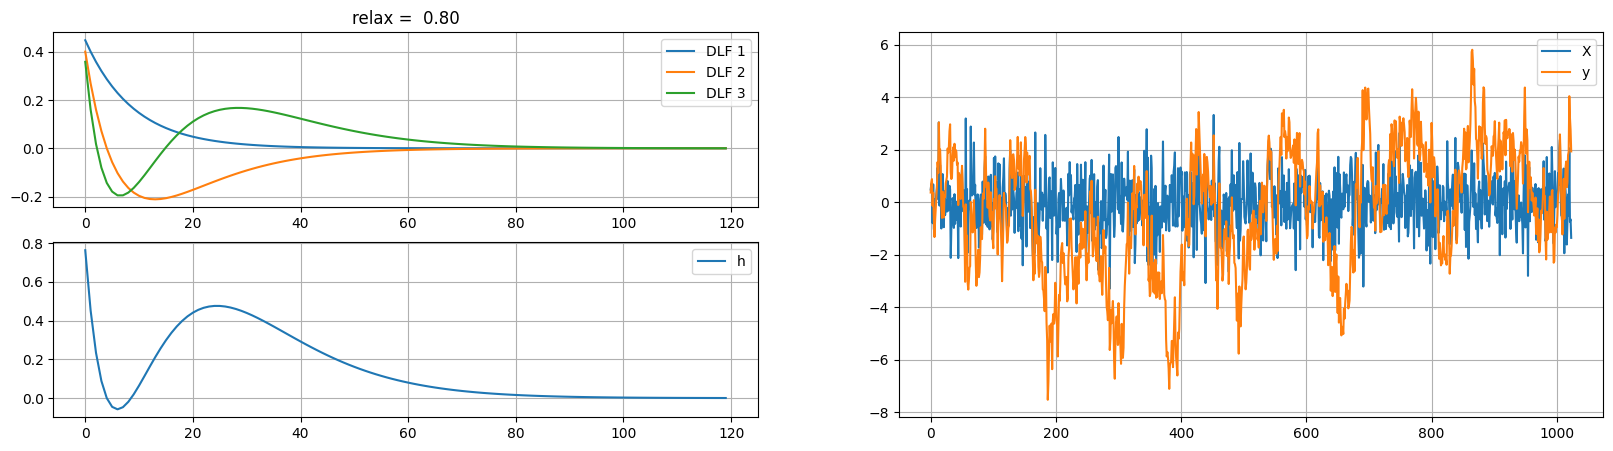

In [6]:

lru = LRU(input_size = 1, hidden_size = 3, relax_init = [0.8])

b = lru.generate_laguerre_functions(120)

w = torch.tensor([[1., -1., 2.]])

N = 1024

t = torch.arange(N)

X = torch.randn((1, N, 1))

with torch.no_grad():
  V, _= lru(X)

V = V.reshape(1, N, -1)

h = b.squeeze(1) @ w.t()
y2 = V @ w.t()

fig, ax = plt.subplots(2, 2, figsize = (20, 5))

ax[0,0].plot(b.squeeze(1), label = ['DLF 1', 'DLF 2', 'DLF 3'])
ax[0,0].set_title(f"relax = {lru.relax[0]: .2f}" )
ax[0,0].grid()
ax[0,0].legend()

ax[1,0].plot(h, label = 'h')
ax[1,0].grid()
ax[1,0].legend()

ax[0,1].remove()
ax[1,1].remove()

ax_24 = fig.add_subplot(2, 2, (2, 4))
ax_24.plot(t, X[0], label = 'X')
ax_24.plot(t, y2[0], label = 'y')
ax_24.grid()
ax_24.legend()

The first three discrete Laguerre functions (DLFs) are shown on the top left. The single function `h`, show on the botton left, is generated by taking a linear combination of these three functions according to the weight tensor `w`. The output `y` is generated by applying `w` to the output of the LRU `V`, where the columns of `V1`  are the convolution of the input `X` with the three DLFs. Therefore, `y` is equivalent to the convolution of the `X` with `h`.

With our synthetic data prepared, we may prepare the data to be fed to our `DataModule`. This module employs PyTorch Lightning's `LightningDataModule`, which prepares the data and sets up the training, validation, and testing dataloaders.

To do this, we place the data in a dictionary. `DataModule` expects the input-output data to be 2D, where the columns represent the features of the data and the rows represent each time index. Remember that dictionary must also contain the time variable, which may be 1D.

In [24]:
data = {'X': X[0],
        'y': y2[0],
        't': t}

We may now move on to creating our model. Here, we want to build a single-input-single-output model. This is a good place introduce the general architecture of the model. The full archicture of the model used in TorchTimeSeries is shown below, oriented left-to-right:

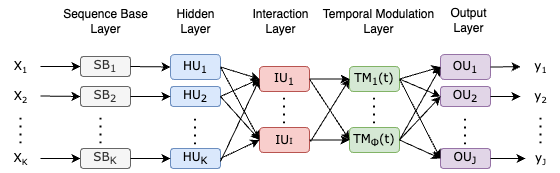

In [25]:

image_path = '/content/TorchTimeSeries/models/SequenceModel.drawio.png'

image = Image.open(image_path)
image.show()


The model is generally a multi-input-multi-output configuration with 5 possible layers.

The first layer is the **sequence base layer**, which serves as a filterbank capturing the dynamics of the input-output relation. Each input `X_k` has its own individual base, which can be a Gated Recurrent Unit (GRU), Long-Short-Term Memory (LSTM) network, Laguerre Recurrent Unit (LRU), or a transformer encoder/decoder.

The second layer is the **input-associated hidden layer**, in which the kth hidden unit (`HU_k`) receives the output of the sequence base layer corresponding to the kth input. This layer allows for the modeling of possible dynamic nonlinearities. The nonlinear activation functions in this layer include commonly used functions such as ReLU, sigmoid, softmax, and tanh. Additionally, a polynomial activation is provided as an alternative nonlinear activation to offer more flexibility.

The third layer is the **interaction layer**, facilitating "cross-talk" between the inputs as they affect the outputs. Unlike the input-associated hidden layer, this layer is fully connected, so that the ith interaction unit (`IU_i`) receives the output of all input-associated hidden units. It provides the same flexibility in the choice of nonlinear activation functions.

The fourth layer is the **temporal modulation layer**, responsible for modeling nonstationary behavior. Note that this layer does not directly model the time-varying characteristics of the input or output, but rather the modulation (multiplication) of the output by various functions. Currently, this layer includes options such as Legendre polynomials, Chebychev polynomials, Fourier basis functions, and the sigmoid function. However, additional functions (such as Hermite and Laguerre) can be added by the user.

Finally, the fifth layer is the **output layer**, which generates the model's outputs.

It's important to note that this is the full architecture, but you can specify a model with fewer layers based on your needs. In our present example, we will build a single-input-single-output architecture with an LRU base.

In [39]:
# model
model = SequenceModel(num_inputs = 1, num_outputs = 1,
                      input_size = [1], output_size = [1],
                      base_type = ['lru'], base_hidden_size = [3],
                      hidden_out_features = [1], hidden_bias = [False],
                      stateful = True)


Here, we have specified that that we have one input and one output, each having one feature. We set the base type for each to be an LRU, both using the first three DLFs. The input-associated hidden layer is set to one feature, since we are modeling a single impulse response. Lastly, we set the model to be stateful, meaning that the hidden states generated by the LRU at a given batch will be passed to the next batch during training. We may summarize the contents of our model by printing its object:

In [41]:
print(model)

seq_base.0.base.relax: shape = torch.Size([1]). 1 parameters. Trainable
hidden_layer.0.F.0.weight: shape = torch.Size([1, 3]). 3 parameters. Trainable
output_layer.0.F.0.weight: shape = torch.Size([1, 1]). 1 parameters. Untrainable
output_layer.0.F.0.bias: shape = torch.Size([1]). 1 parameters. Trainable
-------------------------------------
6 total parameters.
5 total trainable parameters.


We observe that the model is small, having only 6 parameters. Only five of them are trainable, since the inbound weight in the input-associated hidden layer is set to one due to the fact that the number of input and output features are both one, obviating the need for this weight.

Next, we build our datamodule, which depeonds on our custom `DataModule`:

In [43]:

datamodule = DataModule(data = data,
                        time_name = 't', input_names = ['X'], output_names = ['y'],
                        time_unit = 's',
                        transforms = {'all': FeatureTransform('identity')},
                        pct_train_val_test = [0.7, 0.15, 0.15],
                        input_len = [1], output_len = [1],
                        batch_size = 1,
                        shift = [0], stride = 1)


Here, we have given the module our data dictionary and specified which variables are the input and output, along with the name of the time variable. We also tell the module not to transform (using our `FeatureTransform` class), since we know the input is already Guassian with unit variance and zero mean. We specify that we would like to use the first 70% of the entire dataset for training, the next 15% for validation, and the remaining for testing. We inform the module that the length of both the input and output is one, meaning that a given sample at time `t_i` is characterized by `{X_i, y_i}`. We use a single sample per batch, as it has been found that the LRU-based unit trains better when one time point is considered at a time.

Next, we construct our Lightnight module `SequenceModule`, which perform the training and evaluation. We need to provide this module with our model, the criterion used for optimizing the model, and the optimizer used.

In [45]:

# lightingmodule
loss_fn = Loss('mse', dims = (0, 1))

opt = torch.optim.Adam(params = model.parameters(), betas = [0.9, 0.999], lr = 0.002)

seq_module = SequenceModule(model = model,
                            opt = opt, loss_fn = loss_fn,
                            track = True)


Here, we specify that we will use the mean squared error (MSE) as our criterion function. The Adam optimizer with the default hyperparamters is used for optimization. We also wish the track the history of the parameters during training, so we set `track = True`.

At this point, we are ready to train the model. The SequenceModule instance has a `fit` method that is ran by providing the data prepared by our datamodule.

In [ ]:
callbacks = [pl.callbacks.EarlyStopping(monitor = 'val_epoch_loss',
                                        patience = 10,
                                        verbose = False,
                                        min_delta = 0,
                                        mode = 'min')]

seq_module.fit(datamodule = datamodule,
               max_epochs = 20,
               callbacks = callbacks)

We have specified the use of an `EarlyStopping` callback from PyTorch Lightning's callback library. This callback monitors the validation loss (`monitor = 'val_epoch_loss'`) and checks for improvement. If the validation loss does not improve for 5 consecutive epochs (`patience = 5`), training will stop early.

The `min_delta` parameter is set to 0, indicating that any improvement in the validation loss will be considered significant. The `mode` is set to 'min' to indicate that we want to minimize the validation loss.

During the training process, we pass the `datamodule` to the `fit()` function to provide the data for training. The `max_epochs` parameter is set to 500, indicating that we want to train the model for a maximum of 500 epochs.

By including the `callbacks` parameter and specifying the `EarlyStopping` callback, we ensure that the training process will stop if the validation loss does not improve for a specified number of epochs, providing a way to prevent overfitting and optimize the model's performance.

In this case, we've cheated, since we built a model that is based on the exact archicture used to generate the data. Therefore, we should expect perfect results.

Now that the model has been trained. We can look at how well it predicts on the training, validation, and test data. To do this, we rune the `predict` method:

In [47]:
seq_module.predict()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Data length: 155
Window size: 1
Step indices: [0]
Input indices for X: [0]
Output indices for y: [0]


Predicting: 0it [00:00, ?it/s]

The, we can plot the predictions using the `plot_predictions` method

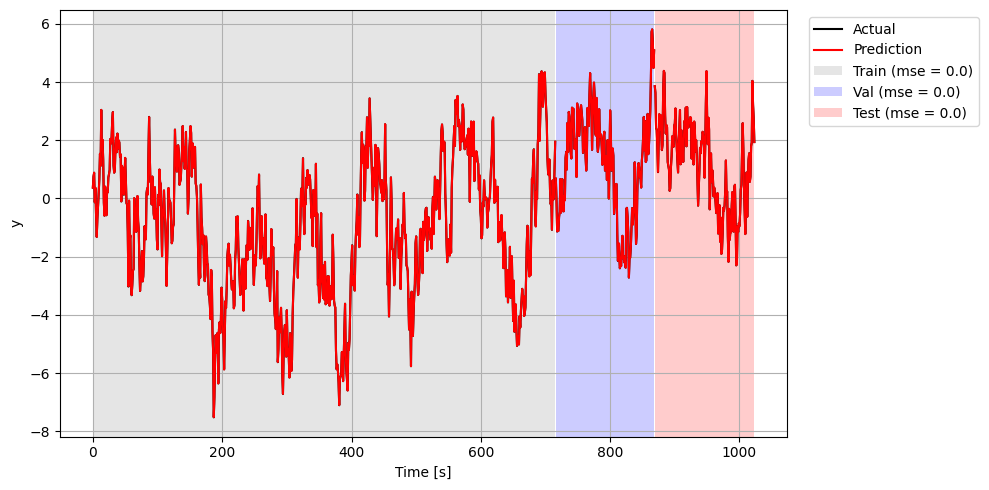

In [48]:
seq_module.plot_predictions()

The plot above shows the actual (black) and predicted (red) output for the training (gray region), validation (blue region) and test (red region) data. As we anticipated the prediction is perfect, so we can't see the actual signal (black trace).

You may visualize the training history with the `plot_history` method. With `track = True` in `SequenceModule`, the history is stored in `train_history` and `val_history` (if validation data is available).

In [50]:
list(seq_module.train_history)

['steps',
 'mse_y',
 'seq_base.0.base.relax',
 'hidden_layer.0.F.0.weight',
 'output_layer.0.F.0.bias']

The training history is collected for each step of the training process, and includes the loss (and metric if specified) and all the trainable parameters. Let's look at the loss, average over the steps in single epoch:

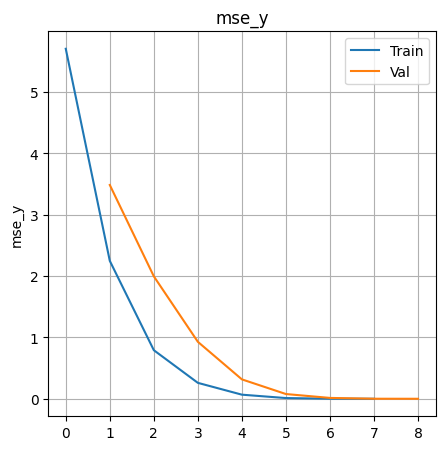

In [52]:
seq_module.plot_history(['mse_y'], plot_train_history_by = 'epochs' )

Again, in this simple example, we should expect both the training and validation loss to approach zero.

Now, let's look at the Laguerre paramters `relax`, which was set to 0.8 to generate the synthetic data.

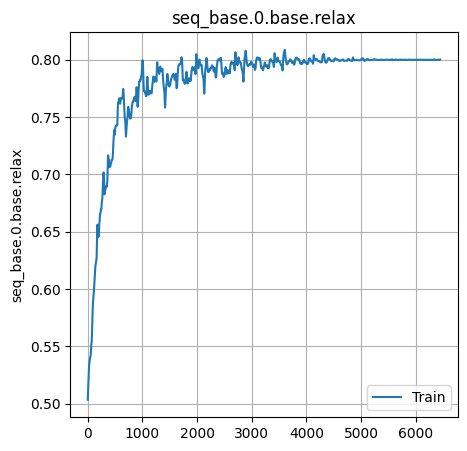

In [53]:
seq_module.plot_history(['seq_base.0.base.relax'], plot_train_history_by = 'steps')

The results are shown over each step, instead of each epoch. Clearly the `relax` parameter converged to its actual value.

In many cases, you might like to examine the characteristics of the model itself, as it may offer insight into the underlying system generating the input-output data. Recall that we generated our data using the output of the `LRU` model, which could be expressed as:

`y = X conv h`

where `h` is our "impulse reponse function." Since, we know what `h` is in this exmaple, we can compare the true `h` with the model-based impulse response.

We can get the model-based impulse response using the `generate_impulse_response` method. Note that to use this method, the model must have an input-associated hidden layer.

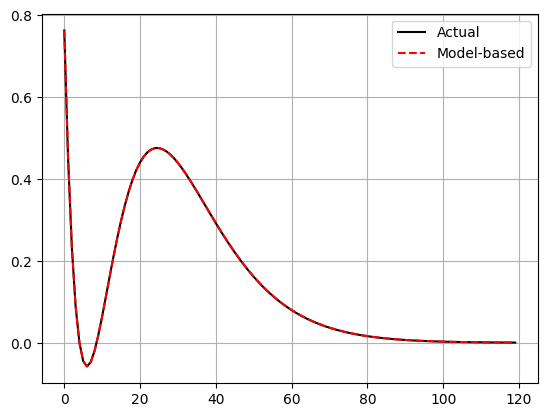

In [56]:
impulse_response = seq_module.model.generate_impulse_response(120)

plt.plot(h, 'k', label = 'Actual')
plt.plot(impulse_response[0][0], '--r', label = 'Model-based')
plt.legend()
plt.grid()

You have successfully built, training, and visualized your model.

Let's try and different model using the same data. Since we know that the data involves the output being some kind of filtered verion of the input, it seems intuitive that a model based on a convolution neural network (CNN) would perform well. Let's try this by replacing the LRU with a 1D CNN. To do this, we just need to change the `base_type` of our model and configure the kernel size of our CNN to match that of our impulse reponse function `h`.

In [60]:
model = SequenceModel(num_inputs = 1, num_outputs = 1,
                      input_size = [1], output_size = [1],
                      base_type = ['cnn'], base_hidden_size = [1], base_cnn_bias = [False],
                      base_cnn_kernel_size = [(120,)],
                      hidden_out_features = [1])

print(model)

seq_base.0.base.weight: shape = torch.Size([1, 1, 120]). 120 parameters. Trainable
hidden_layer.0.F.0.weight: shape = torch.Size([1, 1]). 1 parameters. Untrainable
output_layer.0.F.0.weight: shape = torch.Size([1, 1]). 1 parameters. Untrainable
output_layer.0.F.0.bias: shape = torch.Size([1]). 1 parameters. Trainable
-------------------------------------
123 total parameters.
121 total trainable parameters.


In our CNN-based model, the output value at a given time point is modeled as a linear combination of the present and past 119 input values, plus an offset at the output. This resulting in a total of 121 trainable parameters. There are 123 total parameters due the weights in input-associated hidden layer and output layer, but these untrained since the input and output of both layers have a size of 1. Note that this model is much larger than our previous model, which had only 5 parameters.

We must set the `input_len` to [120] and keep the `output_len` at [1].

In addition, we change our batch size from 1 to -1. This tells `DataModuel` to send all the samples at once in a single batch, however many there are.

Lastly, we pad the data by setting `pad_data = True`. This ensures that all of the available data is used and is not truncated at the beginning. In this case, the training data will be padded with 119 zeros at the beginning of the input sequence. The validation data is padded with the last 119 points of the training data, and the test data is padded with the last 119 points of the validation data.

In [73]:

datamodule = DataModule(data = data,
                        time_name = 't', input_names = ['X'], output_names = ['y'],
                        time_unit = 's',
                        transforms = {'all': FeatureTransform('identity')},
                        pct_train_val_test = [0.7, 0.15, 0.15],
                        input_len = [120], output_len = [1],
                        batch_size = -1,
                        pad_data = True,
                        shift = [0], stride = 1)


In [74]:

# lightingmodule
loss_fn = Loss('mse', dims = (0, 1))

opt = torch.optim.Adam(params = model.parameters(), betas = [0.9, 0.999], lr = 0.002)

seq_module = SequenceModule(model = model,
                            opt = opt, loss_fn = loss_fn,
                            track = True)


In [ ]:
callbacks = [pl.callbacks.EarlyStopping(monitor = 'val_epoch_loss',
                                        patience = 20,
                                        verbose = False,
                                        min_delta = 0,
                                        mode = 'min')]

seq_module.fit(datamodule = datamodule,
               max_epochs = 300,
               callbacks = callbacks)

In [76]:
seq_module.predict()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Data length: 274
Window size: 120
Step indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
Input indices for X: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,

Predicting: 0it [00:00, ?it/s]

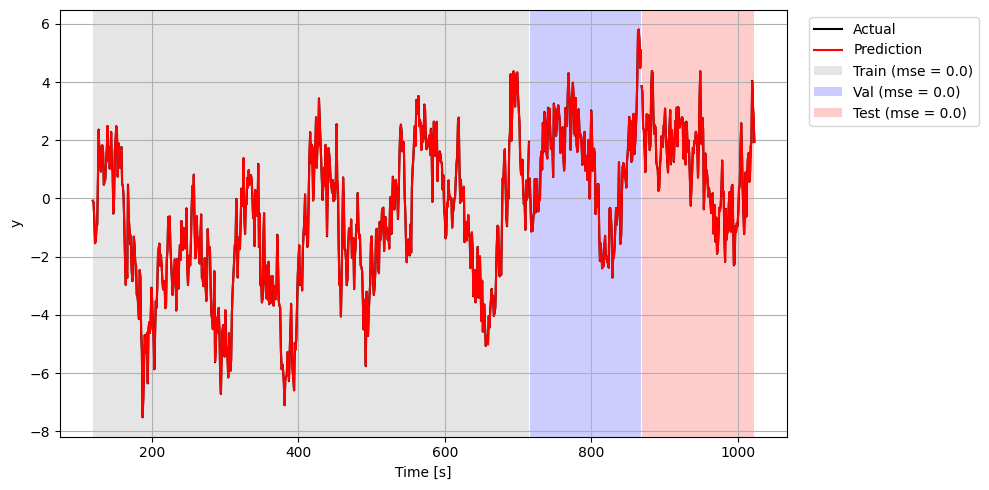

In [77]:
seq_module.plot_predictions()

We observe that the predictive performance of this CNN-based model is near perfect, again as expected.

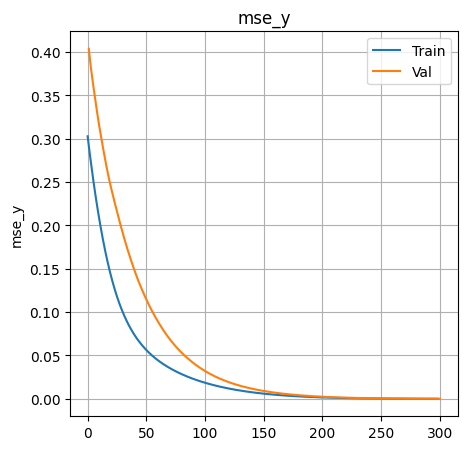

In [78]:
seq_module.plot_history(['mse_y'], plot_train_history_by = 'epochs' )

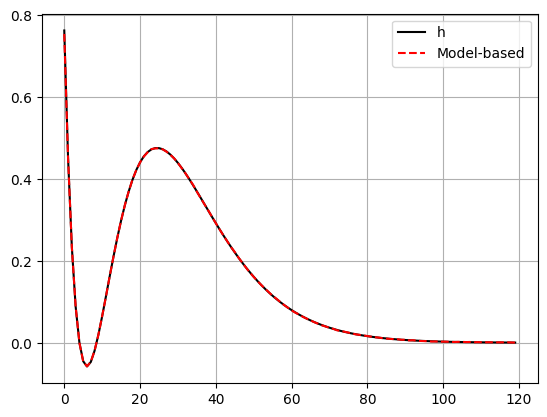

In [94]:
impulse_response = seq_module.model.generate_impulse_response(120)

plt.plot(h, 'k', label = 'h')
plt.plot(impulse_response[0][0], '--r', label = 'Model-based')
plt.legend()
plt.grid()

Again, our predicted impulse response is near perfect. Note that since our model is CNN-based, the kernel itself should have the form of `h`. Let's check by plotting the kernel.

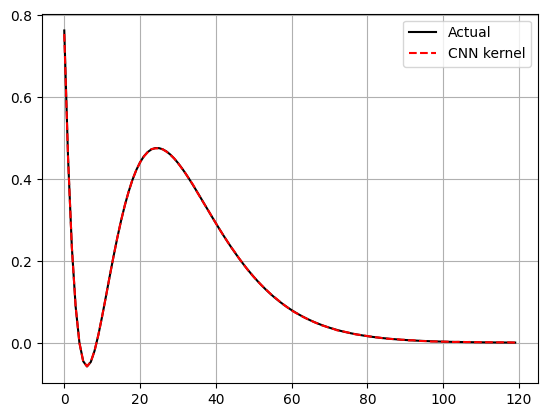

In [93]:
kernel = seq_module.model.seq_base[0].base.weight[0].detach().squeeze().flip(0)

plt.plot(h, 'k', label = 'h')
plt.plot(kernel, '--r', label = 'CNN kernel')
plt.legend()
plt.grid()

Indeed, we also get back the original impulse resonse.

This walkthrough demonstrates how to use the `TorchTimeSeries` package. Please take a look at more [examples](https://github.com/bchenley/TorchTimeSeries/tree/main/examples) to see how the TorchTimeSeries package can be used to model more challenging cases.